In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

import os
import gc
import time
import math
import datetime
from math import log, floor
from sklearn.neighbors import KDTree

import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.utils import shuffle
from tqdm.notebook import tqdm as tqdm

import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

import pywt
from statsmodels.robust import mad

import scipy
import statsmodels
from scipy import signal
import statsmodels.api as sm
from scipy.signal import butter, deconvolve
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import lightgbm as lgb
from sklearn.model_selection import train_test_split

import joblib
from tqdm import tqdm_notebook as tqdm

from sklearn import preprocessing
import sklearn

import warnings
warnings.filterwarnings("ignore")

# Read data

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
from sklearn.preprocessing import OrdinalEncoder

def prep_calendar(df):
    df = df.drop(["weekday", "event_type_1", "event_type_2"], axis=1)
    df = df.assign(d = df.d.str[2:].astype(int))
    to_ordinal = ["event_name_1", "event_name_2"] 
    df[to_ordinal] = df[to_ordinal].fillna("1")
    df[to_ordinal] = OrdinalEncoder(dtype="int").fit_transform(df[to_ordinal]) + 1
    to_int8 = ["wday", "month", "snap_CA", "snap_TX", "snap_WI"] + to_ordinal
    df[to_int8] = df[to_int8].astype("int8")
    
    return df

def read_data(PATH):
    print('Reading files...')
    calendar = pd.read_csv(f'{PATH}/calendar.csv')
    calendar = prep_calendar(calendar)
    print('Calendar has {} rows and {} columns'.format(calendar.shape[0], calendar.shape[1]))
    sell_prices = pd.read_csv(f'{PATH}/sell_prices.csv')
    sell_prices = reduce_mem_usage(sell_prices)
    print('Sell prices has {} rows and {} columns'.format(sell_prices.shape[0], sell_prices.shape[1]))
    sales_train_validation = pd.read_csv(f'{PATH}/sales_train_validation.csv')
    print('Sales train validation has {} rows and {} columns'.format(sales_train_validation.shape[0], sales_train_validation.shape[1]))
    sample_submission = pd.read_csv(f'{PATH}/sample_submission.csv')
    return calendar, sell_prices, sales_train_validation, sample_submission

calendar, selling_prices, sales, sample_submission = read_data("Data")

Reading files...
Calendar has 1969 rows and 11 columns
Mem. usage decreased to 130.48 Mb (37.5% reduction)
Sell prices has 6841121 rows and 4 columns
Sales train validation has 30490 rows and 1919 columns


In [4]:
def higher_level_dataframe(sales):
    sales_train_validation_melt = pd.melt(sales, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name='day', value_name='demand')
    sub_training = sales_train_validation_melt.groupby(['store_id', 'state_id','cat_id','dept_id', 'day'])['demand'].sum()
    sub_training = sub_training.reset_index()
    sub_training['day'] = sub_training['day'].str[2:].astype(int)
    sub_training = sub_training.sort_values(['store_id','state_id','cat_id','dept_id','day'])
    return sub_training

df_l9 = higher_level_dataframe(sales)
df_l9

,store_id,state_id,cat_id,dept_id,day,demand
0,CA_1,CA,FOODS,FOODS_1,1,297
1025,CA_1,CA,FOODS,FOODS_1,2,284
1136,CA_1,CA,FOODS,FOODS_1,3,214
1247,CA_1,CA,FOODS,FOODS_1,4,175
1358,CA_1,CA,FOODS,FOODS_1,5,182
...,...,...,...,...,...,...
133008,WI_3,WI,HOUSEHOLD,HOUSEHOLD_2,1909,148
133010,WI_3,WI,HOUSEHOLD,HOUSEHOLD_2,1910,142
133011,WI_3,WI,HOUSEHOLD,HOUSEHOLD_2,1911,166
133012,WI_3,WI,HOUSEHOLD,HOUSEHOLD_2,1912,232


In [5]:
sub_pivoted = pd.read_csv("Data/Postprocessing-baseline.csv")
sub_pivoted

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_evaluation,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,FOODS_1_001_CA_1_validation,0.640609,0.664005,0.724942,0.647375,0.772233,0.981796,0.918900,0.641279,0.687906,...,0.789530,0.906055,0.901028,0.631739,0.664787,0.704563,0.674574,0.750106,0.913914,0.875751
2,FOODS_1_001_CA_2_evaluation,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3,FOODS_1_001_CA_2_validation,1.032614,0.944698,0.896369,0.947130,1.028244,1.227799,1.272074,1.055621,0.998468,...,1.084416,1.115832,1.101278,0.774754,0.745109,0.750444,0.789070,0.913110,1.149880,1.116391
4,FOODS_1_001_CA_3_evaluation,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60975,HOUSEHOLD_2_516_WI_1_validation,0.088988,0.090018,0.090100,0.083770,0.095559,0.119792,0.106321,0.096470,0.088895,...,0.116950,0.146848,0.135692,0.106453,0.094003,0.094189,0.098404,0.114100,0.137179,0.131015
60976,HOUSEHOLD_2_516_WI_2_evaluation,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
60977,HOUSEHOLD_2_516_WI_2_validation,0.080585,0.077768,0.078140,0.081631,0.091092,0.085616,0.081694,0.092700,0.089562,...,0.099446,0.110044,0.106343,0.087005,0.084948,0.087421,0.093515,0.106971,0.115549,0.110592
60978,HOUSEHOLD_2_516_WI_3_evaluation,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Evaluation code

In [6]:
from tqdm.notebook import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from typing import Union


class WRMSSEEvaluator(object):

    def __init__(self, train_df: pd.DataFrame, valid_df: pd.DataFrame, 
                 calendar: pd.DataFrame, prices: pd.DataFrame):
        train_y = train_df.loc[:, train_df.columns.str.startswith('d_')]
        train_target_columns = train_y.columns.tolist()
        weight_columns = train_y.iloc[:, -28:].columns.tolist()

        train_df['all_id'] = 'all'  # for lv1 aggregation

        id_columns = train_df.loc[:, ~train_df.columns.str.startswith('d_')]\
                     .columns.tolist()
        valid_target_columns = valid_df.loc[:, valid_df.columns.str.startswith('d_')]\
                               .columns.tolist()

        if not all([c in valid_df.columns for c in id_columns]):
            valid_df = pd.concat([train_df[id_columns], valid_df], 
                                 axis=1, sort=False)

        self.train_df = train_df
        self.valid_df = valid_df
        self.calendar = calendar
        self.prices = prices

        self.weight_columns = weight_columns
        self.id_columns = id_columns
        self.valid_target_columns = valid_target_columns

        weight_df = self.get_weight_df()

        self.group_ids = (
            'all_id',
            'state_id',
            'store_id',
            'cat_id',
            'dept_id',
            ['state_id', 'cat_id'],
            ['state_id', 'dept_id'],
            ['store_id', 'cat_id'],
            ['store_id', 'dept_id'],
            'item_id',
            ['item_id', 'state_id'],
            ['item_id', 'store_id']
        )

        for i, group_id in enumerate(tqdm(self.group_ids)):
            train_y = train_df.groupby(group_id)[train_target_columns].sum()
            scale = []
            for _, row in train_y.iterrows():
                series = row.values[np.argmax(row.values != 0):]
                scale.append(((series[1:] - series[:-1]) ** 2).mean())
            setattr(self, f'lv{i + 1}_scale', np.array(scale))
            setattr(self, f'lv{i + 1}_train_df', train_y)
            setattr(self, f'lv{i + 1}_valid_df', valid_df.groupby(group_id)\
                    [valid_target_columns].sum())

            lv_weight = weight_df.groupby(group_id)[weight_columns].sum().sum(axis=1)
            setattr(self, f'lv{i + 1}_weight', lv_weight / lv_weight.sum())

    def get_weight_df(self) -> pd.DataFrame:
        day_to_week = self.calendar.set_index('d')['wm_yr_wk'].to_dict()
        weight_df = self.train_df[['item_id', 'store_id'] + self.weight_columns]\
                    .set_index(['item_id', 'store_id'])
        weight_df = weight_df.stack().reset_index()\
                   .rename(columns={'level_2': 'd', 0: 'value'})
        weight_df['wm_yr_wk'] = weight_df['d'].map(day_to_week)

        weight_df = weight_df.merge(self.prices, how='left',
                                    on=['item_id', 'store_id', 'wm_yr_wk'])
        weight_df['value'] = weight_df['value'] * weight_df['sell_price']
        weight_df = weight_df.set_index(['item_id', 'store_id', 'd'])\
                    .unstack(level=2)['value']\
                    .loc[zip(self.train_df.item_id, self.train_df.store_id), :]\
                    .reset_index(drop=True)
        weight_df = pd.concat([self.train_df[self.id_columns],
                               weight_df], axis=1, sort=False)
        return weight_df

    def rmsse(self, valid_preds: pd.DataFrame, lv: int) -> pd.Series:
        valid_y = getattr(self, f'lv{lv}_valid_df')
        score = ((valid_y - valid_preds) ** 2).mean(axis=1)
        scale = getattr(self, f'lv{lv}_scale')
        return (score / scale).map(np.sqrt) 

    def score(self, valid_preds: Union[pd.DataFrame, 
                                       np.ndarray]) -> float:
        assert self.valid_df[self.valid_target_columns].shape \
               == valid_preds.shape

        if isinstance(valid_preds, np.ndarray):
            valid_preds = pd.DataFrame(valid_preds, 
                                       columns=self.valid_target_columns)

        valid_preds = pd.concat([self.valid_df[self.id_columns], 
                                 valid_preds], axis=1, sort=False)

        all_scores = []
        for i, group_id in enumerate(self.group_ids):

            valid_preds_grp = valid_preds.groupby(group_id)[self.valid_target_columns].sum()
            setattr(self, f'lv{i + 1}_valid_preds', valid_preds_grp)
            
            lv_scores = self.rmsse(valid_preds_grp, i + 1)
            setattr(self, f'lv{i + 1}_scores', lv_scores)
            
            weight = getattr(self, f'lv{i + 1}_weight')
            lv_scores = pd.concat([weight, lv_scores], axis=1, 
                                  sort=False).prod(axis=1)
            
            all_scores.append(lv_scores.sum())
            
        self.all_scores = all_scores

        return np.mean(all_scores)

def create_viz_df(df,lv):
    
    df = df.T.reset_index()
    if lv in [6,7,8,9,11,12]:
        df.columns = [i[0] + '_' + i[1] if i != ('index','') else i[0] for i in df.columns]
    df = df.merge(calendar.loc[:, ['d','date']], how='left', 
                  left_on='index', right_on='d')
    df['date'] = pd.to_datetime(df.date)
    df = df.set_index('date')
    df = df.drop(['index', 'd'], axis=1)
    
    return df

def create_dashboard(evaluator, title='WRMSSE by level'):
    sns.set(font_scale=1.8)
    
    wrmsses = [np.mean(evaluator.all_scores)] + evaluator.all_scores
    labels = ['All'] + [f'{i}' for i in range(1, 13)]

    ## WRMSSE by Level
    plt.figure(figsize=(12,5))
    ax = sns.barplot(x=labels, y=wrmsses)
    ax.set(xlabel='Level', ylabel='WRMSSE')
    plt.title(title, fontsize=20, fontweight='bold')
    for index, val in enumerate(wrmsses):
        ax.text(index*1, val+.01, round(val,2), color='black', 
                ha="center")

        
gc.collect()

0

In [7]:
def evaluator_WRMSSEE(sales, sub_pivoted, path):
    train_df = sales.iloc[:, :-28]
    valid_df = sales.iloc[:, -28:]
    calendar = pd.read_csv(os.path.join(path, "calendar.csv"))

    valid_preds_id = train_df['id']
    valid_preds_df = pd.DataFrame(valid_preds_id)
    valid_preds_df = valid_preds_df.merge(sub_pivoted, on=['id'], how='inner')
    cols =['id']
    for i in range(28):
        cols.append('d_{}'.format(1886+i))
    valid_preds_df.columns = cols
    valid_preds_df = valid_preds_df.drop(columns='id')

    evaluator = WRMSSEEvaluator(train_df, valid_df, calendar, selling_prices)
    WRMSSEE = evaluator.score(valid_preds_df.values)
    print(WRMSSEE)
    
    return evaluator

# Results submission days 1886-1913, effect of rounding

Score of the original results



0.5325992447571287


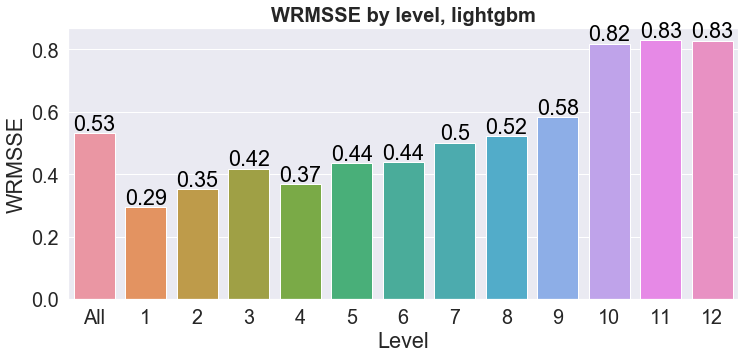

In [8]:
print('Score of the original results')
ev1 = evaluator_WRMSSEE(sales, sub_pivoted, "Data")
create_dashboard(ev1, title='WRMSSE by level, lightgbm')

round certainty with 0.1



0.5336355392561964


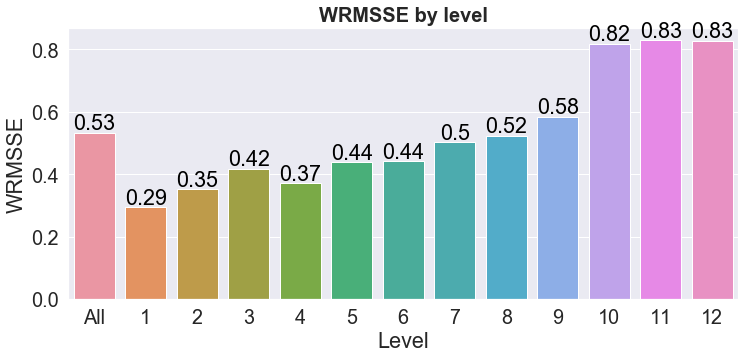

In [9]:
print('round certainty with 0.1')
sub_pivoted2 = sub_pivoted.copy()
F = [col for col in sub_pivoted2 if col.startswith('F')]
sub_pivoted2.update(sub_pivoted2[F][abs(sub_pivoted2[F].round() - sub_pivoted2[F])<0.1].round())
ev2 = evaluator_WRMSSEE(sales, sub_pivoted2, "Data")
create_dashboard(ev2)

round all predictions



0.6356226999156251


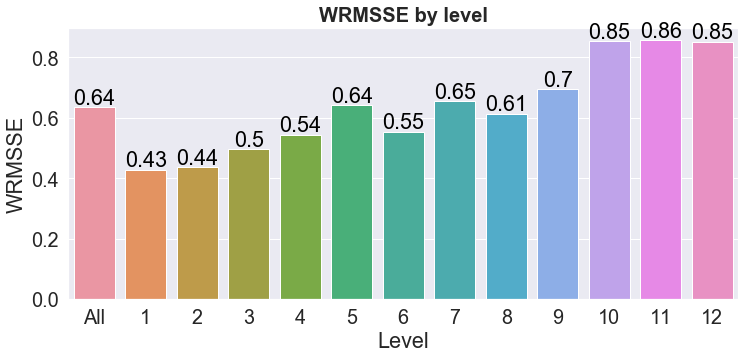

In [10]:
print('round all predictions')
ev3 = evaluator_WRMSSEE(sales, sub_pivoted.round(), "Data")
create_dashboard(ev3)

# set to zero measurements

Score after changing to zeros



0.5388451323802795
MSE after  setting to 0 3.7015491314493127
MSE before setting to 0 3.369541145112008


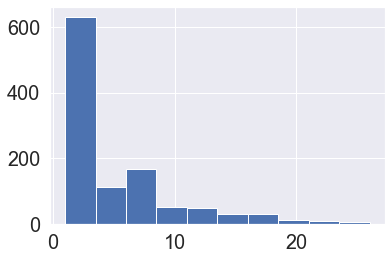

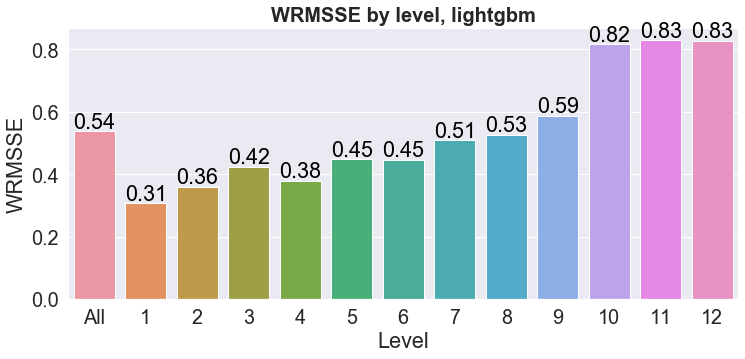

In [11]:
#amount of days before predictions that should be 0
range_days = 56

#prep to select the partitions of the sales dataframe
sub_pivoted = pd.read_csv("Data/Postprocessing-baseline.csv")
sales2 = sales.copy()
previous_cols = ['id']
next_cols = ['id']
F = []
for d in range(range_days):
    previous_cols.append('d_'+str(1885-d))
for d2 in range(28):
    next_cols.append('d_'+str(1886+d2))
    F.append('F'+str(d2+1))

#filter ids with only zeros in the last days before the prediction
sales_previous_week = sales2[previous_cols]
sales2['days not sold'] = (sales_previous_week == 0).astype(int).sum(axis=1)
sales_next = sales2[sales2['days not sold']==range_days][next_cols]

#manual check if we indeed get mostly zeros in the predicted range
plt.hist((sales_next != 0).astype(int).sum(axis=1))

#overwrite submision where last days for prediction were all zeros
sub_pivoted.loc[sub_pivoted['id'].isin(sales_next['id']), F] = 0

print('Score after changing to zeros')
ev1 = evaluator_WRMSSEE(sales, sub_pivoted, "Data")
create_dashboard(ev1, title='WRMSSE by level, lightgbm')


#calculate MSE before and after the change, specifically for the rows that are included
sub_pivoted = pd.read_csv("Data/submission1886-1913.csv")
GT = np.array(sales_next.sort_values('id').drop('id', axis=1))
P = np.array(sub_pivoted[sub_pivoted['id'].isin(sales_next['id'])].sort_values('id').drop('id',axis=1))
MSE_0 = np.mean(GT**2)
MSE_sub = np.mean(np.abs(P-GT)**2)
print('MSE after  setting to 0', MSE_0)
print('MSE before setting to 0', MSE_sub)

Score after changing to zeros



0.5490396069082154
MSE after  setting to 0 2.1738350063152296
MSE before setting to 0 2.084838129429406


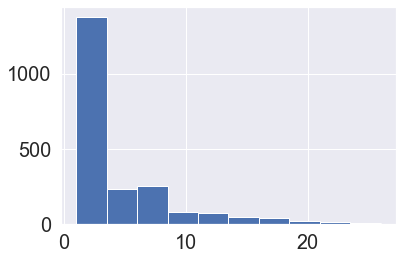

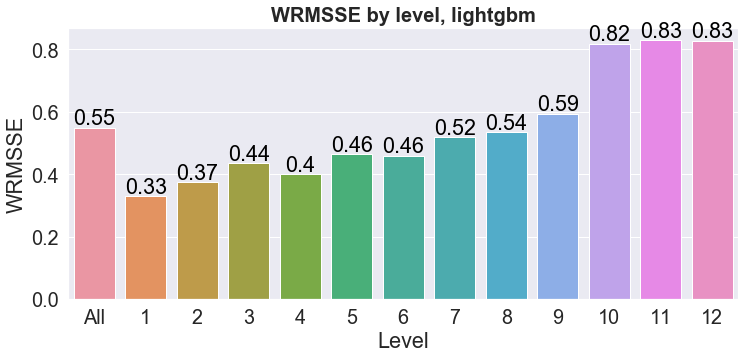

In [12]:
#amount of days before predictions that should be 0
range_days = 28

#prep to select the partitions of the sales dataframe
sub_pivoted = pd.read_csv("Data/Postprocessing-baseline.csv")
sales2 = sales.copy()
previous_cols = ['id']
next_cols = ['id']
F = []
for d in range(range_days):
    previous_cols.append('d_'+str(1885-d))
for d2 in range(28):
    next_cols.append('d_'+str(1886+d2))
    F.append('F'+str(d2+1))

#filter ids with only zeros in the last days before the prediction
sales_previous_week = sales2[previous_cols]
sales2['days not sold'] = (sales_previous_week == 0).astype(int).sum(axis=1)
sales_next = sales2[sales2['days not sold']==range_days][next_cols]

#manual check if we indeed get mostly zeros in the predicted range
plt.hist((sales_next != 0).astype(int).sum(axis=1))

#overwrite submision where last days for prediction were all zeros
sub_pivoted.loc[sub_pivoted['id'].isin(sales_next['id']), F] = 0

print('Score after changing to zeros')
ev1 = evaluator_WRMSSEE(sales, sub_pivoted, "Data")
create_dashboard(ev1, title='WRMSSE by level, lightgbm')

#calculate MSE before and after the change, specifically for the rows that are included
sub_pivoted = pd.read_csv("Data/submission1886-1913.csv")
GT = np.array(sales_next.sort_values('id').drop('id', axis=1))
P = np.array(sub_pivoted[sub_pivoted['id'].isin(sales_next['id'])].sort_values('id').drop('id',axis=1))
MSE_0 = np.mean(GT**2)
MSE_sub = np.mean(np.abs(P-GT)**2)
print('MSE after  setting to 0', MSE_0)
print('MSE before setting to 0', MSE_sub)

Score after changing to zeros



0.565748318792533
MSE after  setting to 0 1.893356287181159
MSE before setting to 0 1.8167267491376178


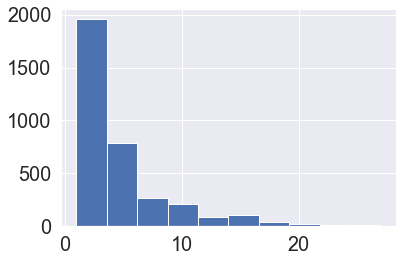

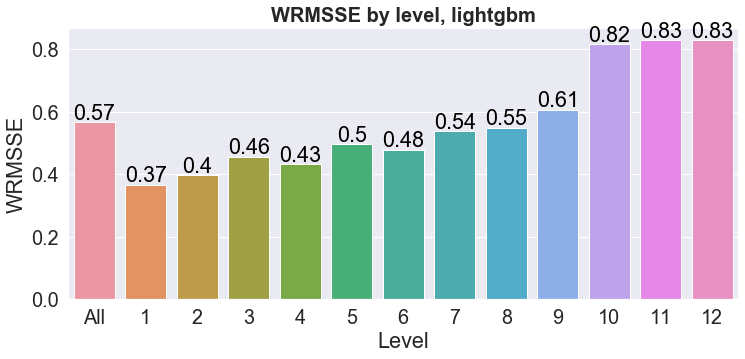

In [13]:
#amount of days before predictions that should be 0
range_days = 14

#prep to select the partitions of the sales dataframe
sub_pivoted = pd.read_csv("Data/Postprocessing-baseline.csv")
sales2 = sales.copy()
previous_cols = ['id']
next_cols = ['id']
F = []
for d in range(range_days):
    previous_cols.append('d_'+str(1885-d))
for d2 in range(28):
    next_cols.append('d_'+str(1886+d2))
    F.append('F'+str(d2+1))

#filter ids with only zeros in the last days before the prediction
sales_previous_week = sales2[previous_cols]
sales2['days not sold'] = (sales_previous_week == 0).astype(int).sum(axis=1)
sales_next = sales2[sales2['days not sold']==range_days][next_cols]

#manual check if we indeed get mostly zeros in the predicted range
plt.hist((sales_next != 0).astype(int).sum(axis=1))

#overwrite submision where last days for prediction were all zeros
sub_pivoted.loc[sub_pivoted['id'].isin(sales_next['id']), F] = 0

print('Score after changing to zeros')
ev1 = evaluator_WRMSSEE(sales, sub_pivoted, "Data")
create_dashboard(ev1, title='WRMSSE by level, lightgbm')

#calculate MSE before and after the change, specifically for the rows that are included
sub_pivoted = pd.read_csv("Data/submission1886-1913.csv")
GT = np.array(sales_next.sort_values('id').drop('id', axis=1))
P = np.array(sub_pivoted[sub_pivoted['id'].isin(sales_next['id'])].sort_values('id').drop('id',axis=1))
MSE_0 = np.mean(GT**2)
MSE_sub = np.mean(np.abs(P-GT)**2)
print('MSE after  setting to 0', MSE_0)
print('MSE before setting to 0', MSE_sub)

Score after changing to zeros



0.6091785898411216
MSE after  setting to 0 1.5967838444278235
MSE before setting to 0 1.469182656769165


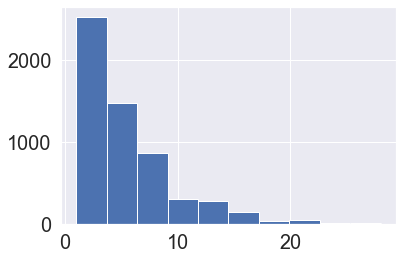

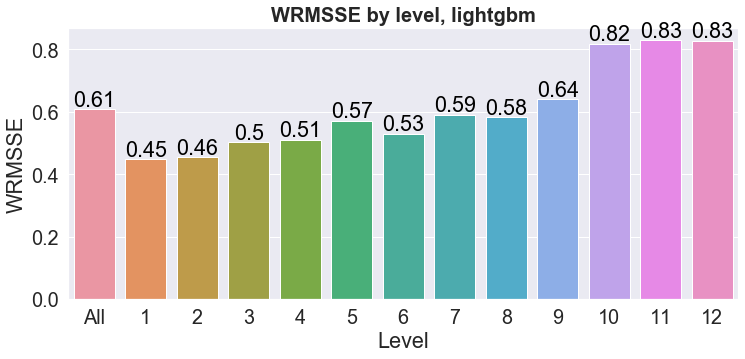

In [14]:
#amount of days before predictions that should be 0
range_days = 7

#prep to select the partitions of the sales dataframe
sub_pivoted = pd.read_csv("Data/Postprocessing-baseline.csv")
sales2 = sales.copy()
previous_cols = ['id']
next_cols = ['id']
F = []
for d in range(range_days):
    previous_cols.append('d_'+str(1885-d))
for d2 in range(28):
    next_cols.append('d_'+str(1886+d2))
    F.append('F'+str(d2+1))

#filter ids with only zeros in the last days before the prediction
sales_previous_week = sales2[previous_cols]
sales2['days not sold'] = (sales_previous_week == 0).astype(int).sum(axis=1)
sales_next = sales2[sales2['days not sold']==range_days][next_cols]

#manual check if we indeed get mostly zeros in the predicted range
plt.hist((sales_next != 0).astype(int).sum(axis=1))

#overwrite submision where last days for prediction were all zeros
sub_pivoted.loc[sub_pivoted['id'].isin(sales_next['id']), F] = 0

print('Score after changing to zeros')
ev1 = evaluator_WRMSSEE(sales, sub_pivoted, "Data")
create_dashboard(ev1, title='WRMSSE by level, lightgbm')

#calculate MSE before and after the change, specifically for the rows that are included
sub_pivoted = pd.read_csv("Data/submission1886-1913.csv")
GT = np.array(sales_next.sort_values('id').drop('id', axis=1))
P = np.array(sub_pivoted[sub_pivoted['id'].isin(sales_next['id'])].sort_values('id').drop('id',axis=1))
MSE_0 = np.mean(GT**2)
MSE_sub = np.mean(np.abs(P-GT)**2)
print('MSE after  setting to 0', MSE_0)
print('MSE before setting to 0', MSE_sub)

# Combining high level predictions with rounding

In [15]:
sub_pivoted = pd.read_csv("Data/Postprocessing-baseline.csv")


0.22911630170277278


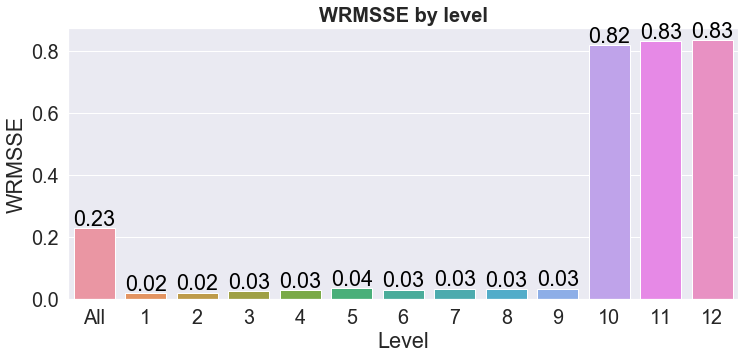

In [16]:
#grouped by store_id and dept_id (level 9)

#column id initialization
level_ids = ['store_id','state_id','cat_id','dept_id']
days = []
for i in range(28):
    days.append('d_'+str(i+1886))

#group the results to level 9
results_inc_level = sales[['id']+level_ids].merge(sub_pivoted)
grouped_results = results_inc_level.groupby(level_ids).sum()

#group the ground truth to level 9 in same format as results
grouped_ground_truth = sales[level_ids+days].groupby(level_ids).sum()
grouped_ground_truth.columns = grouped_results.columns

#calculate misclassification
miscl = grouped_results - grouped_ground_truth
miscl

c = 0

for f in range(28):
    col = 'F'+str(f+1)
    
    for i in range(len(miscl)):
        temp_df = results_inc_level[
                          (results_inc_level[level_ids[0]]==miscl.index[i][0]) &
                          (results_inc_level[level_ids[1]]==miscl.index[i][1]) &
                          (results_inc_level[level_ids[2]]==miscl.index[i][2]) &
                          (results_inc_level[level_ids[3]]==miscl.index[i][3])
                         ][col]
        temp_miscl = miscl.reset_index()[
            (miscl.reset_index()[level_ids[0]]==miscl.index[i][0]) &
            (miscl.reset_index()[level_ids[1]]==miscl.index[i][1]) &
            (miscl.reset_index()[level_ids[2]]==miscl.index[i][2]) &
            (miscl.reset_index()[level_ids[3]]==miscl.index[i][3])
        ]
        
        if temp_miscl[col].mean()>0:
            results_inc_level.update(
                temp_df[temp_df.apply(lambda x: x-np.floor(x)).sort_values().cumsum()<abs(temp_miscl[col].mean())]\
                    .apply(np.floor)
            )
        else:
            results_inc_level.update(
                temp_df[temp_df.apply(lambda x: np.ceil(x)-x).sort_values().cumsum()<abs(temp_miscl[col].mean())]\
                    .apply(np.ceil)
            )

ev4 = evaluator_WRMSSEE(sales, results_inc_level.drop(level_ids,axis=1), "Data")
create_dashboard(ev4)


0.38509530756446925


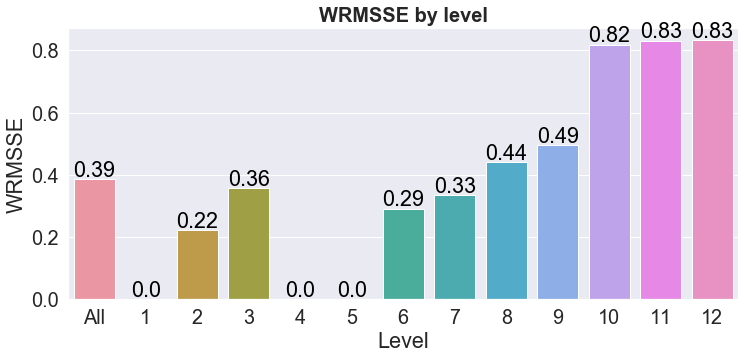

In [17]:
#grouped by dept_id (level 5)

#column id initialization
level_ids = ['cat_id','dept_id']
days = []
for i in range(28):
    days.append('d_'+str(i+1886))

#group the results to level 9
results_inc_level = sales[['id']+level_ids].merge(sub_pivoted)
grouped_results = results_inc_level.groupby(level_ids).sum()

#group the ground truth to level 9 in same format as results
grouped_ground_truth = sales[level_ids+days].groupby(level_ids).sum()
grouped_ground_truth.columns = grouped_results.columns

#calculate misclassification
miscl = grouped_results - grouped_ground_truth
miscl

for f in range(28):
    col = 'F'+str(f+1)
    
    for i in range(len(miscl)):
        temp_df = results_inc_level[
            (results_inc_level[level_ids[0]]==miscl.index[i][0]) &
            (results_inc_level[level_ids[1]]==miscl.index[i][1])
            ][col]
        temp_miscl = miscl.reset_index()[
            (miscl.reset_index()[level_ids[0]]==miscl.index[i][0]) &
            (miscl.reset_index()[level_ids[1]]==miscl.index[i][1])
            ]

        if temp_miscl[col].mean()>0:
            results_inc_level.update(
                temp_df[temp_df.apply(lambda x: x-np.floor(x)).sort_values().cumsum()<abs(temp_miscl[col].mean())]\
                    .apply(np.floor)
            )
        else:
            results_inc_level.update(
                temp_df[temp_df.apply(lambda x: np.ceil(x)-x).sort_values().cumsum()<abs(temp_miscl[col].mean())]\
                    .apply(np.ceil)
            )

ev5 = evaluator_WRMSSEE(sales, results_inc_level.drop(level_ids,axis=1), "Data")
create_dashboard(ev5)


0.3912911819698152


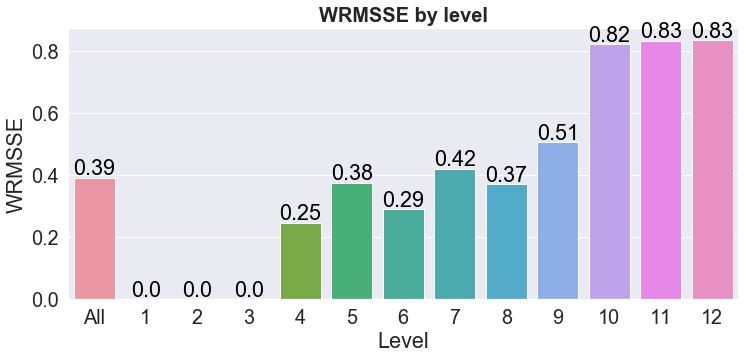

In [18]:
#grouped by store_id (level 3)

#column id initialization
level_ids = ['store_id','state_id']
days = []
for i in range(28):
    days.append('d_'+str(i+1886))

#group the results to level 9
results_inc_level = sales[['id']+level_ids].merge(sub_pivoted)
grouped_results = results_inc_level.groupby(level_ids).sum()

#group the ground truth to level 9 in same format as results
grouped_ground_truth = sales[level_ids+days].groupby(level_ids).sum()
grouped_ground_truth.columns = grouped_results.columns

#calculate misclassification
miscl = grouped_results - grouped_ground_truth
miscl

for f in range(28):
    col = 'F'+str(f+1)
    
    for i in range(len(miscl)):
        temp_df = results_inc_level[
            (results_inc_level[level_ids[0]]==miscl.index[i][0]) &
            (results_inc_level[level_ids[1]]==miscl.index[i][1])
            ][col]
        temp_miscl = miscl.reset_index()[
            (miscl.reset_index()[level_ids[0]]==miscl.index[i][0]) &
            (miscl.reset_index()[level_ids[1]]==miscl.index[i][1])
            ]

        if temp_miscl[col].mean()>0:
            results_inc_level.update(
                temp_df[temp_df.apply(lambda x: x-np.floor(x)).sort_values().cumsum()<abs(temp_miscl[col].mean())]\
                    .apply(np.floor)
            )
        else:
            results_inc_level.update(
                temp_df[temp_df.apply(lambda x: np.ceil(x)-x).sort_values().cumsum()<abs(temp_miscl[col].mean())]\
                    .apply(np.ceil)
            )

ev6 = evaluator_WRMSSEE(sales, results_inc_level.drop(level_ids,axis=1), "Data")
create_dashboard(ev6)

# Using high level predictions with equal contribution

In [19]:
sub_pivoted = pd.read_csv("Data/Postprocessing-baseline.csv")


0.4574070190184656


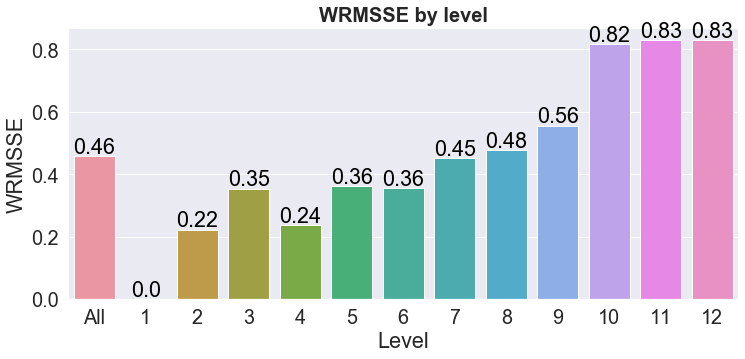

In [20]:
#grouped by (level 1)

#column id initialization
days = []
F = []
for i in range(28):
    days.append('d_'+str(i+1886))
    F.append('F'+str(i+1))

#group the results to level 1
results_inc_level = sales[['id']].merge(sub_pivoted)
grouped_results = results_inc_level.sum()

#group the ground truth to level 1 in same format as results
grouped_ground_truth = sales[days].sum()

#calculate misclassification
miscl = (grouped_results[1:] - np.array(grouped_ground_truth))/len(results_inc_level)

for f in range(28):
    results_inc_level['F'+str(f+1)] = results_inc_level['F'+str(f+1)] - miscl[f]

ev7 = evaluator_WRMSSEE(sales, results_inc_level, "Data")
create_dashboard(ev7)


0.20565530272093926


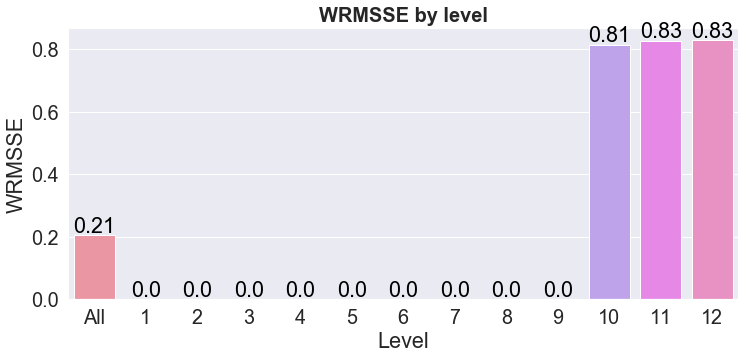

In [21]:
#grouped by level 9

#column id initialization
level_ids = ['store_id','dept_id']
days = []
F = []
for i in range(28):
    days.append('d_'+str(i+1886))
    F.append('F'+str(i+1))

#group the results to level 9
results_inc_level = sales[['id']+level_ids].merge(sub_pivoted)
grouped_results = results_inc_level.groupby(level_ids).sum()

#group the ground truth to level 9 in same format as results
grouped_ground_truth = sales[level_ids+days].groupby(level_ids).sum()
grouped_ground_truth.columns = grouped_results.columns

#calculate misclassification
miscl = grouped_results - grouped_ground_truth
correction = miscl.div(results_inc_level.groupby(level_ids).size(),axis=0)

correction_per_F = results_inc_level.join(correction, on=level_ids,rsuffix='_cor')
for f in range(28):
    results_inc_level['F'+str(f+1)] = results_inc_level['F'+str(f+1)] - correction_per_F['F'+str(f+1)+'_cor']

ev8 = evaluator_WRMSSEE(sales, results_inc_level.drop(level_ids,axis=1), "Data")
create_dashboard(ev8)


0.28324030269917294


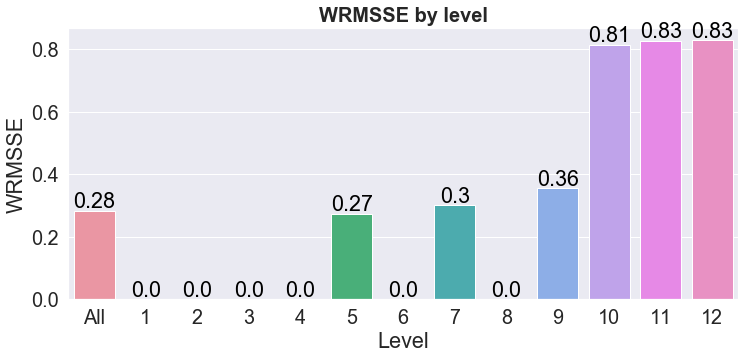

In [22]:
#grouped by level 8

#column id initialization
level_ids = ['cat_id','store_id']
days = []
F = []
for i in range(28):
    days.append('d_'+str(i+1886))
    F.append('F'+str(i+1))

#group the results to level 8
results_inc_level = sales[['id']+level_ids].merge(sub_pivoted)
grouped_results = results_inc_level.groupby(level_ids).sum()

#group the ground truth to level 8 in same format as results
grouped_ground_truth = sales[level_ids+days].groupby(level_ids).sum()
grouped_ground_truth.columns = grouped_results.columns

#calculate misclassification
miscl = grouped_results - grouped_ground_truth
correction = miscl.div(results_inc_level.groupby(level_ids).size(),axis=0)

correction_per_F = results_inc_level.join(correction, on=level_ids,rsuffix='_cor')
for f in range(28):
    results_inc_level['F'+str(f+1)] = results_inc_level['F'+str(f+1)] - correction_per_F['F'+str(f+1)+'_cor']

ev10 = evaluator_WRMSSEE(sales, results_inc_level.drop(level_ids,axis=1), "Data")
create_dashboard(ev10)


0.2929124573928821


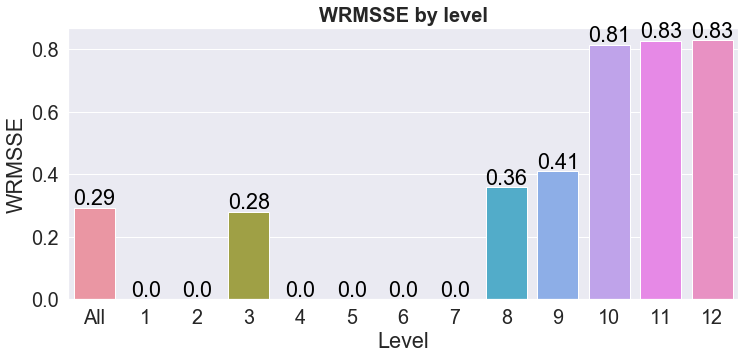

In [23]:
#grouped by level 7

#column id initialization
level_ids = ['dept_id','state_id']
days = []
F = []
for i in range(28):
    days.append('d_'+str(i+1886))
    F.append('F'+str(i+1))

#group the results to level 7
results_inc_level = sales[['id']+level_ids].merge(sub_pivoted)
grouped_results = results_inc_level.groupby(level_ids).sum()

#group the ground truth to level 7 in same format as results
grouped_ground_truth = sales[level_ids+days].groupby(level_ids).sum()
grouped_ground_truth.columns = grouped_results.columns

#calculate misclassification
miscl = grouped_results - grouped_ground_truth
correction = miscl.div(results_inc_level.groupby(level_ids).size(),axis=0)

correction_per_F = results_inc_level.join(correction, on=level_ids,rsuffix='_cor')
for f in range(28):
    results_inc_level['F'+str(f+1)] = results_inc_level['F'+str(f+1)] - correction_per_F['F'+str(f+1)+'_cor']

ev10 = evaluator_WRMSSEE(sales, results_inc_level.drop(level_ids,axis=1), "Data")
create_dashboard(ev10)


0.34751051486706747


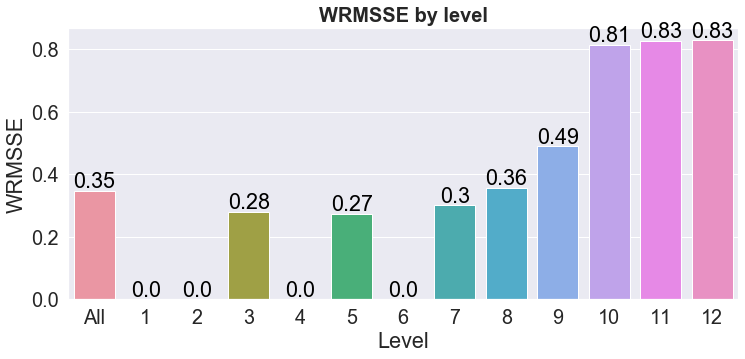

In [24]:
#grouped by level 6

#column id initialization
level_ids = ['cat_id','state_id']
days = []
F = []
for i in range(28):
    days.append('d_'+str(i+1886))
    F.append('F'+str(i+1))

#group the results to level 6
results_inc_level = sales[['id']+level_ids].merge(sub_pivoted)
grouped_results = results_inc_level.groupby(level_ids).sum()

#group the ground truth to level 6 in same format as results
grouped_ground_truth = sales[level_ids+days].groupby(level_ids).sum()
grouped_ground_truth.columns = grouped_results.columns

#calculate misclassification
miscl = grouped_results - grouped_ground_truth
correction = miscl.div(results_inc_level.groupby(level_ids).size(),axis=0)

correction_per_F = results_inc_level.join(correction, on=level_ids,rsuffix='_cor')
for f in range(28):
    results_inc_level['F'+str(f+1)] = results_inc_level['F'+str(f+1)] - correction_per_F['F'+str(f+1)+'_cor']

ev10 = evaluator_WRMSSEE(sales, results_inc_level.drop(level_ids,axis=1), "Data")
create_dashboard(ev10)


0.3844958073688707


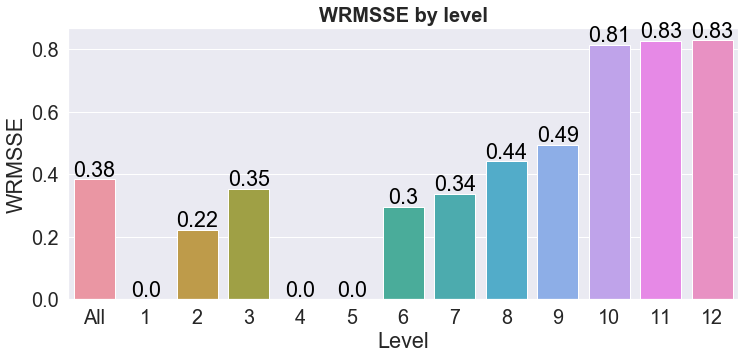

In [25]:
#grouped by level 5

#column id initialization
level_ids = ['cat_id','dept_id']
days = []
F = []
for i in range(28):
    days.append('d_'+str(i+1886))
    F.append('F'+str(i+1))

#group the results to level 5
results_inc_level = sales[['id']+level_ids].merge(sub_pivoted)
grouped_results = results_inc_level.groupby(level_ids).sum()

#group the ground truth to level 5 in same format as results
grouped_ground_truth = sales[level_ids+days].groupby(level_ids).sum()
grouped_ground_truth.columns = grouped_results.columns

#calculate misclassification
miscl = grouped_results - grouped_ground_truth
correction = miscl.div(results_inc_level.groupby(level_ids).size(),axis=0)

correction_per_F = results_inc_level.join(correction, on=level_ids,rsuffix='_cor')
for f in range(28):
    results_inc_level['F'+str(f+1)] = results_inc_level['F'+str(f+1)] - correction_per_F['F'+str(f+1)+'_cor']

ev9 = evaluator_WRMSSEE(sales, results_inc_level.drop(level_ids,axis=1), "Data")
create_dashboard(ev9)


0.41788260453042175


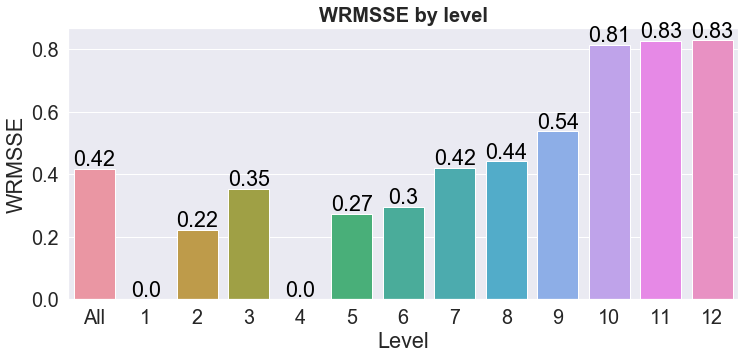

In [26]:
#grouped by level 4

#column id initialization
level_ids = ['cat_id']
days = []
F = []
for i in range(28):
    days.append('d_'+str(i+1886))
    F.append('F'+str(i+1))

#group the results to level 4
results_inc_level = sales[['id']+level_ids].merge(sub_pivoted)
grouped_results = results_inc_level.groupby(level_ids).sum()

#group the ground truth to level 4 in same format as results
grouped_ground_truth = sales[level_ids+days].groupby(level_ids).sum()
grouped_ground_truth.columns = grouped_results.columns

#calculate misclassification
miscl = grouped_results - grouped_ground_truth
correction = miscl.div(results_inc_level.groupby(level_ids).size(),axis=0)

correction_per_F = results_inc_level.join(correction, on=level_ids,rsuffix='_cor')
for f in range(28):
    results_inc_level['F'+str(f+1)] = results_inc_level['F'+str(f+1)] - correction_per_F['F'+str(f+1)+'_cor']

ev10 = evaluator_WRMSSEE(sales, results_inc_level.drop(level_ids,axis=1), "Data")
create_dashboard(ev10)


0.3863504800286908


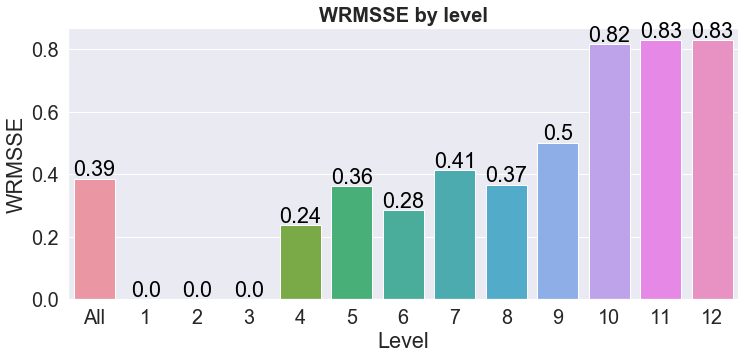

In [27]:
#grouped by level 3

#column id initialization
level_ids = ['store_id','state_id']
days = []
F = []
for i in range(28):
    days.append('d_'+str(i+1886))
    F.append('F'+str(i+1))

#group the results to level 3
results_inc_level = sales[['id']+level_ids].merge(sub_pivoted)
grouped_results = results_inc_level.groupby(level_ids).sum()

#group the ground truth to level 3 in same format as results
grouped_ground_truth = sales[level_ids+days].groupby(level_ids).sum()
grouped_ground_truth.columns = grouped_results.columns

#calculate misclassification
miscl = grouped_results - grouped_ground_truth
correction = miscl.div(results_inc_level.groupby(level_ids).size(),axis=0)

correction_per_F = results_inc_level.join(correction, on=level_ids,rsuffix='_cor')
for f in range(28):
    results_inc_level['F'+str(f+1)] = results_inc_level['F'+str(f+1)] - correction_per_F['F'+str(f+1)+'_cor']

ev10 = evaluator_WRMSSEE(sales, results_inc_level.drop(level_ids,axis=1), "Data")
create_dashboard(ev10)


0.4189882200409754


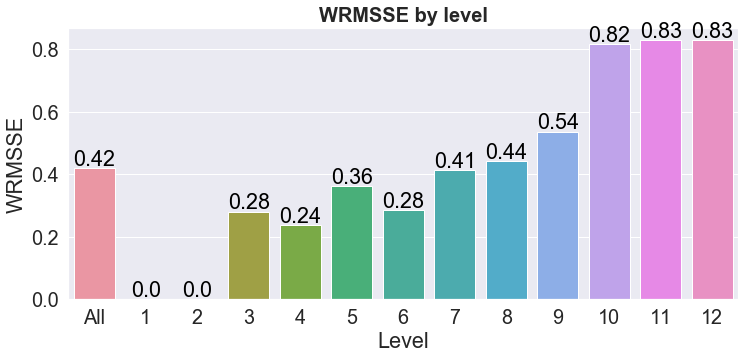

In [28]:
#grouped by level 2

#column id initialization
level_ids = ['state_id']
days = []
F = []
for i in range(28):
    days.append('d_'+str(i+1886))
    F.append('F'+str(i+1))

#group the results to level 2
results_inc_level = sales[['id']+level_ids].merge(sub_pivoted)
grouped_results = results_inc_level.groupby(level_ids).sum()

#group the ground truth to level 2 in same format as results
grouped_ground_truth = sales[level_ids+days].groupby(level_ids).sum()
grouped_ground_truth.columns = grouped_results.columns

#calculate misclassification
miscl = grouped_results - grouped_ground_truth
correction = miscl.div(results_inc_level.groupby(level_ids).size(),axis=0)

correction_per_F = results_inc_level.join(correction, on=level_ids,rsuffix='_cor')
for f in range(28):
    results_inc_level['F'+str(f+1)] = results_inc_level['F'+str(f+1)] - correction_per_F['F'+str(f+1)+'_cor']

ev10 = evaluator_WRMSSEE(sales, results_inc_level.drop(level_ids,axis=1), "Data")
create_dashboard(ev10)